# Hong Kong Food Clusters analysis

## Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Understand Data](#U_data)
* [Clustering](#Clustering)
* [Analysis](#analysis)
* [Conclusion](#conclusion)

## Introduction: <a name="introduction"></a>

Searching for a dinner place is always a daily question in many people's mind. Some people may find their ideas from food guides or magazine recommendations. However, there is not much information about how restaurant spread over hong kong. It would be interesting to understand what food choices do we have in the areas, what kinds of restaurants are more likely comes together and how the different restaurant categories form the districts.

This project will analyze the geographic distribution of restaurants from a data science perspective and we will analyze the cuisine's clusters and the price levels around hong kong. Hopefully, It would be a good figure for consumers to make their choices.


## 1. Import Library and set up Foresquare API

In [13]:
import numpy as np 
import pandas as pd
import requests
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize # handle json to dataframe
from folium.plugins import HeatMap #folium heat map
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans

mpl.style.use('ggplot') # optional: for ggplot-like style

CLIENT_ID = 'HYPHVSN5ZS2JQW33YVJPOJIFPIWQHF40JSIFJYCPO1MJLTVT' # your Foursquare ID
CLIENT_SECRET = 'CUAOMPRHQQMT4LNHU2RDPYFTNGZJ4WK5F2ISGRABAWHJYE3G' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
address = 'Hong Kong'
latitude = 22.306
longitude = 114.19

## Data <a name="data"></a>

## 2. Data acquisition and cleaning

### For Simplicity, assuming that we explore hong kong restaurant near MTR lines. 

In order to neglect suburban areas, we would like to foucus the center part of the city which is well covered by the Kwun Tong Line, Island Line, part of Tsuen Wan Line and some popular stations.

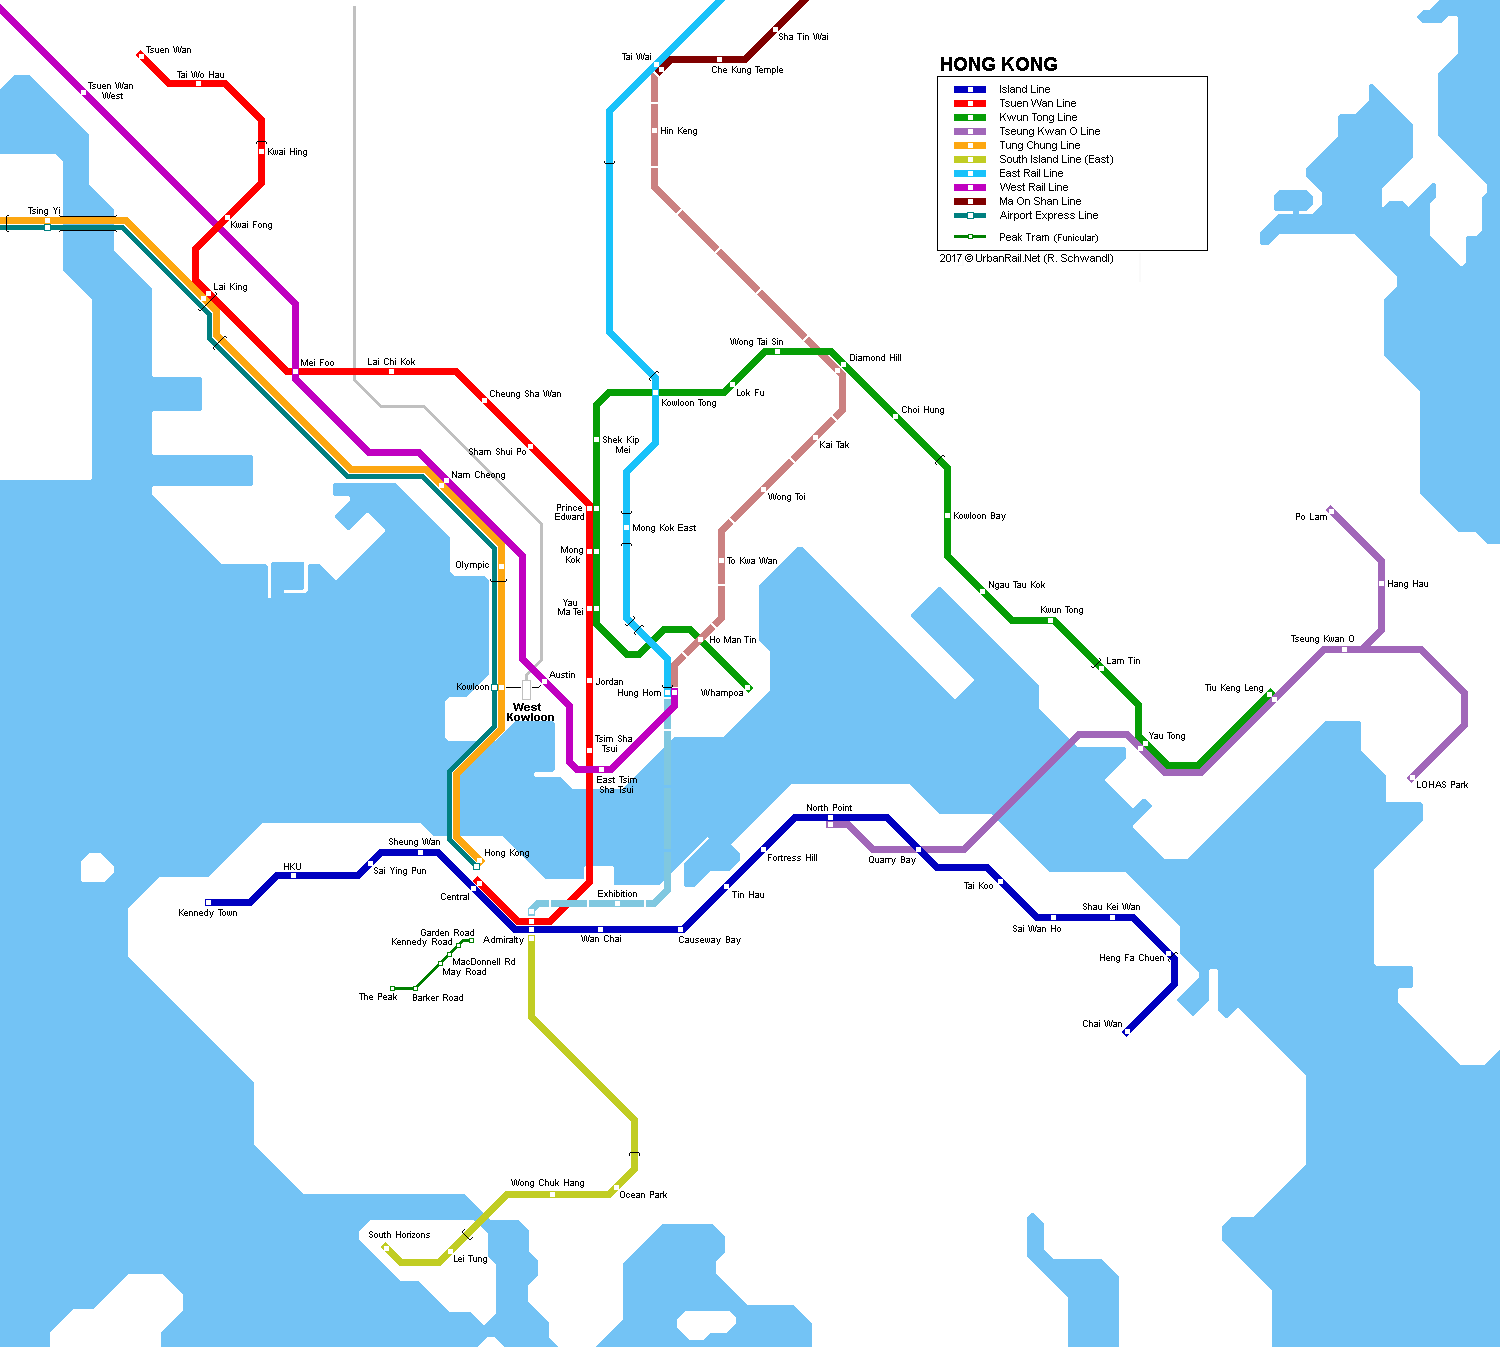

### The below station names were chosen for restaruant data acquisition.

Some stations are not recognizable by Foursquare site, we substitute them with the location name of that area.

- Whampoa -> HUNG HOM 
- HKU -> SHEK TONG TSUI
- Wan Chai -> Wanchai
- Central -> CENTRAL,HK
- Wong Tai Sin -> CHUK YUEN
- Kowloon -> Austin
-  Olympic-> Olympic,hk

In [2]:
# ----------- Kwun Tong Line + Island Line ------------
districts = {'HUNG HOM',
'Ho Man Tin',
'Yau Ma Tei',
'Mong Kok',
'Prince Edward',
'Shek Kip Mei',
'Kowloon Tong',
'Lok Fu',
'CHUK YUEN',
'Diamond Hill',
'Choi Hung',
'Kowloon Bay',
'Ngau Tau Kok',
'Kwun Tong',
'Lam Tin',
'Yau Tong',
'Kennedy Town',
'SHEK TONG TSUI',
'Sai Ying Pun',
'Sheung Wan',
'CENTRAL,HK',
'Admiralty',
'Wanchai',
'Causeway Bay',
'Tin Hau',
'Fortress Hill',
'North Point',
'Quarry Bay',
'Tai Koo',
'Sai Wan Ho',
'Shau Kei Wan',
'Heng Fa Chuen',
'Chai Wan',
'Olympic,hk',
'Tsim Sha Tsui',
'Kowloon'
}


## 3. Collecting restaurant data through Fouresquare API

#### Define a function that request the restaruant data of each station and run it

In [3]:
def restaruant_api ( NEAR = None ):
    #categoryid 4d4b7105d754a06374d81259 is food
    categoryId = '4d4b7105d754a06374d81259'
    radius = 900
    limit = 500
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&near={}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET,NEAR, VERSION, categoryId, radius,limit)
    url

    results = requests.get(url).json()
    # assign relevant part of JSON to venues
    print( NEAR,':' )
    venues = results['response']['venues']
    # tranform venues into a dataframe
    
    dataframe = json_normalize(venues)
    if(dataframe.shape[0] < 1):
        return  pd.DataFrame()
    dataframe.head()
    dataframe['categories'] = dataframe['categories'].apply(lambda x : x[0]['name'])
    dataframe['near'] = NEAR
    return dataframe

# calling the restaurant_api fucntion
dfs = []
for district_name in districts:
    dataframe = restaruant_api(district_name)
    dfs.append(dataframe)

hk_restaurant = pd.concat(dfs,axis = 0,sort= True)
hk_restaurant.head()

Kowloon Bay :
Yau Tong :
Ngau Tau Kok :
Quarry Bay :
Shek Kip Mei :
Prince Edward :
Kennedy Town :
Admiralty :
Yau Ma Tei :
Tin Hau :
Shau Kei Wan :
Mong Kok :
Kowloon Tong :
Choi Hung :
CHUK YUEN :
Heng Fa Chuen :
Sai Ying Pun :
Tai Koo :
Fortress Hill :
Ho Man Tin :
Lam Tin :
Kwun Tong :
Causeway Bay :
HUNG HOM :
SHEK TONG TSUI :
CENTRAL,HK :
Wanchai :
North Point :
Kowloon :
Chai Wan :
Olympic,hk :
Lok Fu :
Tsim Sha Tsui :
Sheung Wan :
Sai Wan Ho :
Diamond Hill :


categories  hasPerk                        id  \
0  Cantonese Restaurant    False  5850ede153f5bb50da26e599   
1   Japanese Restaurant    False  58ac203b7a8f046a82d35e6e   
2           Coffee Shop    False  4d82ecdef9f3a1cd44aa9664   
3            Food Court    False  4d9d636cc99fb60c3d71c68b   
4   Shanghai Restaurant    False  5937e16cf79faa70e69586c3   

                                    location.address location.cc  \
0  1/F, Goldin Financial Global Centre, 17 Kai Ch...          HK   
1  2/F, Goldin Financial Global Centre,17 Kai Che...          HK   
2       Shop 3, G/F, Skyline Tower, 39 Wang Kwong Rd          HK   
3                       Kai Yip Estate, Wang Chiu Rd          HK   
4                                                NaN          HK   

  location.city location.country location.crossStreet  \
0   Kowloon Bay               香港                  NaN   
1   Kowloon Bay               香港                  NaN   
2   Kowloon Bay               香港                  NaN   
3   Kowloon Bay               香港                  NaN   
4           NaN               香港                  NaN   

                           location.formattedAddress  \
0  [1/F, Goldin Financial Global Centre, 17 Kai C...   
1  [2/F, Goldin Financial Global Centre,17 Kai Ch...   
2  [Shop 3, G/F, Skyline Tower, 39 Wang Kwong Rd,...   
3                 [Kai Yip Estate, Wang Chiu Rd, 香港]   
4                                               [香港]   

                             location.labeledLatLngs  location.lat  \
0  [{'label': 'display', 'lat': 22.325647, 'lng':...     22.325647   
1  [{'label': 'display', 'lat': 22.325562, 'lng':...     22.325562   
2  [{'label': 'display', 'lat': 22.32655810518935...     22.326558   
3  [{'label': 'display', 'lat': 22.32816666666666...     22.328167   
4  [{'label': 'display', 'lat': 22.324398, 'lng':...     22.324398   

   location.lng location.neighborhood location.postalCode location.state  \
0    114.206697         Jordan Valley                 NaN            NaN   
1    114.206870                   NaN                 NaN            NaN   
2    114.205666                   NaN                 NaN            NaN   
3    114.208778           Kowloon Bay                 NaN            NaN   
4    114.213400                   NaN                 NaN            NaN   

                                           name         near    referralId  \
0                              Congeodle (江南庭敘)  Kowloon Bay  v-1559419011   
1                              Matsunichi (大松日)  Kowloon Bay  v-1559419011   
2                          Pacific Coffee 太平洋咖啡  Kowloon Bay  v-1559419011   
3           Kai Yip Cooked Food Stalls (啟業熟食中心)  Kowloon Bay  v-1559419011   
4  Crystal Jade La Mian Xiao Long Bao (翡翠拉麵小籠包)  Kowloon Bay  v-1559419011   

  venuePage.id  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN

In [4]:
hk_restaurant.shape

(1749, 19)

Total 1749 rows data returned.

## Understand Data <a name="U_data"></a>

## 4. Explore the return Data

### 4.1 Restaurant Map

#### Let's visualize the data, Create a map of Hong Kong with restaurant superimposed on top.

In [7]:
# select useful features
restauran_df =hk_restaurant[['name','location.lat','location.lng','categories']]
# create a folium map 
food_map = folium.Map(location=[latitude, longitude], zoom_start=13)
# add markers to map
for lat, lng, name, categories in zip(restauran_df['location.lat'], restauran_df['location.lng'], restauran_df['name'], restauran_df['categories']):
    label = '{}, {}'.format(name, categories)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(food_map)  

food_map

Let's check how many restaurant were returned for each category

### 4.2 Top 15 Restaurant Categories Plot

#### Ploting the Fequency Distribution for top 15 most common categories

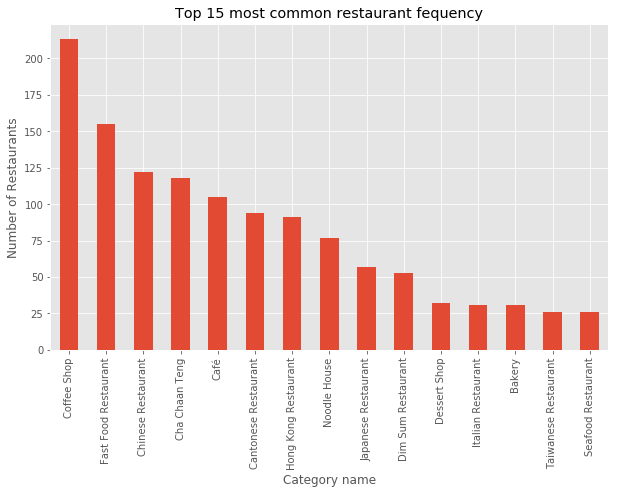

In [8]:
category_polt = restauran_df.groupby('categories').count().sort_values(by=['name'],ascending=False)
category_polt = category_polt[:15]
category_polt = category_polt['name']
count, bin_edges = np.histogram(category_polt)

category_polt.plot(kind='bar', figsize=(10, 6))
plt.title('Top 15 most common restaurant fequency') # add a title to the bar chat
plt.ylabel('Number of Restaurants') # add y-label
plt.xlabel('Category name') # add x-label
plt.show()

In [9]:
print('There are {} uniques categories.'.format(len(restauran_df['categories'].unique())))

There are 91 uniques categories.


### 4.3 Top 10 most common categories dataframe

#### Create a DataFrame Showing the Top 10 Most Common Categories of each location

In [10]:
# one hot encoding
restaurant_cat_onehot = pd.get_dummies(hk_restaurant[['categories']], prefix="", prefix_sep="")
# add Near column back to dataframe
restaurant_cat_onehot['Near'] = hk_restaurant['near'] 
# move Near column to the first column
fixed_columns = [restaurant_cat_onehot.columns[-1]] + list(restaurant_cat_onehot.columns[:-1])
restaurant_cat_onehot = restaurant_cat_onehot[fixed_columns]
restaurant_group = restaurant_cat_onehot.groupby('Near').mean().reset_index()

In [11]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


num_top_resturant = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Near']
for ind in np.arange(num_top_resturant):
    try:
        columns.append('{}{} Most Common Category'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Category'.format(ind+1))

# create a new dataframe
restaurant_group_sorted = pd.DataFrame(columns=columns)
restaurant_group_sorted['Near'] = restaurant_group['Near']

for ind in np.arange(restaurant_group.shape[0]):
    restaurant_group_sorted.iloc[ind, 1:] = return_most_common_venues(restaurant_group.iloc[ind, :], num_top_resturant)

restaurant_group_sorted.head()

Near 1st Most Common Category 2nd Most Common Category  \
0     Admiralty                     Café              Coffee Shop   
1    CENTRAL,HK              Coffee Shop                     Café   
2     CHUK YUEN       Chinese Restaurant              Coffee Shop   
3  Causeway Bay              Coffee Shop           Cha Chaan Teng   
4      Chai Wan     Fast Food Restaurant     Hong Kong Restaurant   

  3rd Most Common Category 4th Most Common Category 5th Most Common Category  \
0       Dim Sum Restaurant     Fast Food Restaurant       Italian Restaurant   
1       Dim Sum Restaurant     Fast Food Restaurant             Noodle House   
2           Cha Chaan Teng     Cantonese Restaurant              Pizza Place   
3     Hong Kong Restaurant             Noodle House       Chinese Restaurant   
4       Chinese Restaurant           Cha Chaan Teng              Coffee Shop   

  6th Most Common Category 7th Most Common Category 8th Most Common Category  \
0             Noodle House           Sandwich Place             Burger Joint   
1       Italian Restaurant             Burger Joint           Sandwich Place   
2       Dim Sum Restaurant      Japanese Restaurant     Hong Kong Restaurant   
3     Cantonese Restaurant           Sandwich Place     Fast Food Restaurant   
4               Restaurant             Noodle House                Cafeteria   

  9th Most Common Category 10th Most Common Category  
0       Chinese Restaurant      Cantonese Restaurant  
1       Chinese Restaurant            Cha Chaan Teng  
2                     Café          Sushi Restaurant  
3               Restaurant          Ramen Restaurant  
4     Taiwanese Restaurant      Cantonese Restaurant

## Clustering <a name="Clustering"></a>

### 5.1 Applying Clustering Algorithm

#### Run *k*-means to cluster the locations into 5 clusters

In [14]:
# set number of clusters
kclusters = 5

restaurant_group_clustering = restaurant_group.drop('Near', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(restaurant_group_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# add clustering labels
restaurant_group_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# Merge Cluster labels with dataset
restaurant_merged = hk_restaurant

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
restaurant_merged = restaurant_merged.join(restaurant_group_sorted.set_index('Near'), on='near')
restaurant_merged.head() # check the last columns!

categories  hasPerk                        id  \
0  Cantonese Restaurant    False  5850ede153f5bb50da26e599   
1   Japanese Restaurant    False  58ac203b7a8f046a82d35e6e   
2           Coffee Shop    False  4d82ecdef9f3a1cd44aa9664   
3            Food Court    False  4d9d636cc99fb60c3d71c68b   
4   Shanghai Restaurant    False  5937e16cf79faa70e69586c3   

                                    location.address location.cc  \
0  1/F, Goldin Financial Global Centre, 17 Kai Ch...          HK   
1  2/F, Goldin Financial Global Centre,17 Kai Che...          HK   
2       Shop 3, G/F, Skyline Tower, 39 Wang Kwong Rd          HK   
3                       Kai Yip Estate, Wang Chiu Rd          HK   
4                                                NaN          HK   

  location.city location.country location.crossStreet  \
0   Kowloon Bay               香港                  NaN   
1   Kowloon Bay               香港                  NaN   
2   Kowloon Bay               香港                  NaN   
3   Kowloon Bay               香港                  NaN   
4           NaN               香港                  NaN   

                           location.formattedAddress  \
0  [1/F, Goldin Financial Global Centre, 17 Kai C...   
1  [2/F, Goldin Financial Global Centre,17 Kai Ch...   
2  [Shop 3, G/F, Skyline Tower, 39 Wang Kwong Rd,...   
3                 [Kai Yip Estate, Wang Chiu Rd, 香港]   
4                                               [香港]   

                             location.labeledLatLngs  ...  \
0  [{'label': 'display', 'lat': 22.325647, 'lng':...  ...   
1  [{'label': 'display', 'lat': 22.325562, 'lng':...  ...   
2  [{'label': 'display', 'lat': 22.32655810518935...  ...   
3  [{'label': 'display', 'lat': 22.32816666666666...  ...   
4  [{'label': 'display', 'lat': 22.324398, 'lng':...  ...   

   1st Most Common Category  2nd Most Common Category  \
0               Coffee Shop      Fast Food Restaurant   
1               Coffee Shop      Fast Food Restaurant   
2               Coffee Shop      Fast Food Restaurant   
3               Coffee Shop      Fast Food Restaurant   
4               Coffee Shop      Fast Food Restaurant   

  3rd Most Common Category 4th Most Common Category 5th Most Common Category  \
0       Chinese Restaurant     Hong Kong Restaurant     Cantonese Restaurant   
1       Chinese Restaurant     Hong Kong Restaurant     Cantonese Restaurant   
2       Chinese Restaurant     Hong Kong Restaurant     Cantonese Restaurant   
3       Chinese Restaurant     Hong Kong Restaurant     Cantonese Restaurant   
4       Chinese Restaurant     Hong Kong Restaurant     Cantonese Restaurant   

  6th Most Common Category 7th Most Common Category 8th Most Common Category  \
0      Japanese Restaurant                     Café             Noodle House   
1      Japanese Restaurant                     Café             Noodle House   
2      Japanese Restaurant                     Café             Noodle House   
3      Japanese Restaurant                     Café             Noodle House   
4      Japanese Restaurant                     Café             Noodle House   

  9th Most Common Category  10th Most Common Category  
0           Cha Chaan Teng        Shanghai Restaurant  
1           Cha Chaan Teng        Shanghai Restaurant  
2           Cha Chaan Teng        Shanghai Restaurant  
3           Cha Chaan Teng        Shanghai Restaurant  
4           Cha Chaan Teng        Shanghai Restaurant  

[5 rows x 30 columns]

### 5.2 Map visualization

#### Finally, let's visualize the resulting clusters

In [15]:
restaurant_merged
# create map
restaurant_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi,cat,near,cluster in zip(restaurant_merged['location.lat'], restaurant_merged['location.lng'], restaurant_merged['name'],restaurant_merged['categories'], restaurant_merged['near'], restaurant_merged['Cluster Labels']):
    label = folium.Popup(str(poi) +' Near :' + str(near) +' Cat :' +str(cat) + ' Cluster :' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(restaurant_clusters)
       
restaurant_clusters


### 5.3 Examine Clusters

In [16]:
restaurant_group_sorted.groupby('Cluster Labels').count()

Near  1st Most Common Category  2nd Most Common Category  \
Cluster Labels                                                             
0                  5                         5                         5   
1                 14                        14                        14   
2                  8                         8                         8   
3                  7                         7                         7   
4                  1                         1                         1   

                3rd Most Common Category  4th Most Common Category  \
Cluster Labels                                                       
0                                      5                         5   
1                                     14                        14   
2                                      8                         8   
3                                      7                         7   
4                                      1                         1   

                5th Most Common Category  6th Most Common Category  \
Cluster Labels                                                       
0                                      5                         5   
1                                     14                        14   
2                                      8                         8   
3                                      7                         7   
4                                      1                         1   

                7th Most Common Category  8th Most Common Category  \
Cluster Labels                                                       
0                                      5                         5   
1                                     14                        14   
2                                      8                         8   
3                                      7                         7   
4                                      1                         1   

                9th Most Common Category  10th Most Common Category  
Cluster Labels                                                       
0                                      5                          5  
1                                     14                         14  
2                                      8                          8  
3                                      7                          7  
4                                      1                          1

#### 5.3.1 1st Clusters :

In [17]:
restaurant_group_sorted.loc[restaurant_group_sorted['Cluster Labels'] == 0]

Cluster Labels          Near 1st Most Common Category  \
0                0     Admiralty                     Café   
1                0    CENTRAL,HK              Coffee Shop   
14               0  Kowloon Tong                     Café   
28               0    Sheung Wan              Coffee Shop   
32               0       Wanchai                     Café   

   2nd Most Common Category 3rd Most Common Category 4th Most Common Category  \
0               Coffee Shop       Dim Sum Restaurant     Fast Food Restaurant   
1                      Café       Dim Sum Restaurant     Fast Food Restaurant   
14              Coffee Shop       Chinese Restaurant     Fast Food Restaurant   
28                     Café       Dim Sum Restaurant     Cantonese Restaurant   
32              Coffee Shop     Fast Food Restaurant              Pizza Place   

   5th Most Common Category 6th Most Common Category 7th Most Common Category  \
0        Italian Restaurant             Noodle House           Sandwich Place   
1              Noodle House       Italian Restaurant             Burger Joint   
14       Italian Restaurant           Cha Chaan Teng     Hong Kong Restaurant   
28             Noodle House       Italian Restaurant      Japanese Restaurant   
32       Seafood Restaurant       Dim Sum Restaurant             Noodle House   

   8th Most Common Category 9th Most Common Category 10th Most Common Category  
0              Burger Joint       Chinese Restaurant      Cantonese Restaurant  
1            Sandwich Place       Chinese Restaurant            Cha Chaan Teng  
14                   Bakery     Taiwanese Restaurant                Restaurant  
28           Sandwich Place       Chinese Restaurant            Cha Chaan Teng  
32           Cha Chaan Teng     Cantonese Restaurant            Sandwich Place

#### 5.3.2  2nd Cluster：

In [18]:
restaurant_group_sorted.loc[restaurant_group_sorted['Cluster Labels'] == 1]

Cluster Labels           Near 1st Most Common Category  \
2                1      CHUK YUEN       Chinese Restaurant   
4                1       Chai Wan     Fast Food Restaurant   
5                1      Choi Hung     Fast Food Restaurant   
6                1   Diamond Hill           Cha Chaan Teng   
7                1  Fortress Hill     Fast Food Restaurant   
9                1  Heng Fa Chuen             Noodle House   
12               1        Kowloon       Chinese Restaurant   
15               1      Kwun Tong     Fast Food Restaurant   
16               1        Lam Tin       Chinese Restaurant   
17               1         Lok Fu           Cha Chaan Teng   
19               1   Ngau Tau Kok     Fast Food Restaurant   
20               1    North Point     Fast Food Restaurant   
21               1     Olympic,hk     Fast Food Restaurant   
26               1   Shau Kei Wan     Fast Food Restaurant   

   2nd Most Common Category 3rd Most Common Category 4th Most Common Category  \
2               Coffee Shop           Cha Chaan Teng     Cantonese Restaurant   
4      Hong Kong Restaurant       Chinese Restaurant           Cha Chaan Teng   
5      Cantonese Restaurant       Chinese Restaurant           Cha Chaan Teng   
6               Coffee Shop     Hong Kong Restaurant       Chinese Restaurant   
7            Cha Chaan Teng              Coffee Shop             Noodle House   
9      Fast Food Restaurant         Ramen Restaurant       Chinese Restaurant   
12          Thai Restaurant              Coffee Shop                     Café   
15           Cha Chaan Teng     Cantonese Restaurant              Coffee Shop   
16     Fast Food Restaurant             Noodle House     Hong Kong Restaurant   
17       Chinese Restaurant     Cantonese Restaurant             Dessert Shop   
19       Chinese Restaurant                     Café             Noodle House   
20           Cha Chaan Teng              Coffee Shop     Cantonese Restaurant   
21       Chinese Restaurant              Coffee Shop           Cha Chaan Teng   
26           Cha Chaan Teng             Noodle House             Dessert Shop   

   5th Most Common Category 6th Most Common Category 7th Most Common Category  \
2               Pizza Place       Dim Sum Restaurant      Japanese Restaurant   
4               Coffee Shop               Restaurant             Noodle House   
5        Dim Sum Restaurant     Hong Kong Restaurant         Sushi Restaurant   
6          Sushi Restaurant     Cantonese Restaurant                     Café   
7        Chinese Restaurant                     Café      Japanese Restaurant   
9                      Café          Thai Restaurant                Cafeteria   
12     Fast Food Restaurant             Noodle House           Cha Chaan Teng   
15       Chinese Restaurant     Hong Kong Restaurant                     Café   
16                   Bakery           Cha Chaan Teng      Japanese Restaurant   
17              Coffee Shop          Thai Restaurant             Noodle House   
19     Cantonese Restaurant           Cha Chaan Teng              Coffee Shop   
20     Hong Kong Restaurant             Noodle House                     Café   
21      Japanese Restaurant       Dim Sum Restaurant          Bubble Tea Shop   
26       Chinese Restaurant          Bubble Tea Shop        Indian Restaurant   

   8th Most Common Category 9th Most Common Category 10th Most Common Category  
2      Hong Kong Restaurant                     Café          Sushi Restaurant  
4                 Cafeteria     Taiwanese Restaurant      Cantonese Restaurant  
5                      Café              Coffee Shop     Vietnamese Restaurant  
6              Noodle House     Fast Food Restaurant        Dim Sum Restaurant  
7      Cantonese Restaurant                BBQ Joint        Italian Restaurant  
9      Hong Kong Restaurant               Restaurant      Cantonese Restaurant  
12             Dessert Shop       Dim Sum Restaurant          Halal Restau

#### 5.3.3  3rd Cluster：

In [19]:
restaurant_group_sorted.loc[restaurant_group_sorted['Cluster Labels'] == 2]

Cluster Labels            Near 1st Most Common Category  \
3                2    Causeway Bay              Coffee Shop   
11               2    Kennedy Town              Coffee Shop   
23               2  SHEK TONG TSUI              Coffee Shop   
25               2    Sai Ying Pun              Coffee Shop   
27               2    Shek Kip Mei              Coffee Shop   
30               2         Tin Hau              Coffee Shop   
31               2   Tsim Sha Tsui              Coffee Shop   
33               2      Yau Ma Tei              Coffee Shop   

   2nd Most Common Category 3rd Most Common Category 4th Most Common Category  \
3            Cha Chaan Teng     Hong Kong Restaurant             Noodle House   
11           Cha Chaan Teng                Gastropub     Fast Food Restaurant   
23       Chinese Restaurant        French Restaurant                Gastropub   
25     Cantonese Restaurant       Chinese Restaurant       Italian Restaurant   
27           Cha Chaan Teng             Noodle House             Dessert Shop   
30                     Café           Cha Chaan Teng     Fast Food Restaurant   
31     Fast Food Restaurant           Cha Chaan Teng             Noodle House   
33     Fast Food Restaurant       Chinese Restaurant     Hong Kong Restaurant   

   5th Most Common Category 6th Most Common Category 7th Most Common Category  \
3        Chinese Restaurant     Cantonese Restaurant           Sandwich Place   
11       Chinese Restaurant       Mexican Restaurant           Breakfast Spot   
23       Mexican Restaurant       Dim Sum Restaurant                   Bakery   
25                     Café        French Restaurant         Tapas Restaurant   
27       Chinese Restaurant              Snack Place       Dim Sum Restaurant   
30             Noodle House     Hong Kong Restaurant                BBQ Joint   
31             Dessert Shop      Shanghai Restaurant              Snack Place   
33           Cha Chaan Teng       Dim Sum Restaurant             Dessert Shop   

   8th Most Common Category 9th Most Common Category 10th Most Common Category  
3      Fast Food Restaurant               Restaurant          Ramen Restaurant  
11       Dim Sum Restaurant                     Café        English Restaurant  
23           Cha Chaan Teng     Cantonese Restaurant            Breakfast Spot  
25      Japanese Restaurant                   Bakery              Noodle House  
27                     Café                   Bakery       Dumpling Restaurant  
30       Chinese Restaurant      Japanese Restaurant      Cantonese Restaurant  
31          Bubble Tea Shop         Ramen Restaurant        Dim Sum Restaurant  
33             Noodle House     Cantonese Restaurant       Shanghai Restaurant

#### 5.3.4  4th Cluster：

In [20]:
restaurant_group_sorted.loc[restaurant_group_sorted['Cluster Labels'] == 3]

Cluster Labels         Near 1st Most Common Category  \
8                3     HUNG HOM              Coffee Shop   
10               3   Ho Man Tin              Coffee Shop   
13               3  Kowloon Bay              Coffee Shop   
18               3     Mong Kok              Coffee Shop   
22               3   Quarry Bay     Fast Food Restaurant   
24               3   Sai Wan Ho              Coffee Shop   
29               3      Tai Koo              Coffee Shop   

   2nd Most Common Category 3rd Most Common Category 4th Most Common Category  \
8      Fast Food Restaurant     Hong Kong Restaurant       Chinese Restaurant   
10     Hong Kong Restaurant     Fast Food Restaurant     Cantonese Restaurant   
13     Fast Food Restaurant       Chinese Restaurant     Hong Kong Restaurant   
18     Fast Food Restaurant     Hong Kong Restaurant     Cantonese Restaurant   
22              Coffee Shop     Cantonese Restaurant     Hong Kong Restaurant   
24     Fast Food Restaurant      Japanese Restaurant     Cantonese Restaurant   
29     Cantonese Restaurant     Fast Food Restaurant      Japanese Restaurant   

   5th Most Common Category 6th Most Common Category 7th Most Common Category  \
8      Cantonese Restaurant                     Café      Japanese Restaurant   
10       Chinese Restaurant       Italian Restaurant           Cha Chaan Teng   
13     Cantonese Restaurant      Japanese Restaurant                     Café   
18       Chinese Restaurant       Dim Sum Restaurant      Japanese Restaurant   
22      Japanese Restaurant                     Café    Vietnamese Restaurant   
24                     Café     Hong Kong Restaurant           Cha Chaan Teng   
29           Cha Chaan Teng                     Café     Hong Kong Restaurant   

   8th Most Common Category 9th Most Common Category 10th Most Common Category  
8          Sushi Restaurant             Noodle House            Cha Chaan Teng  
10      Shanghai Restaurant          Bubble Tea Shop         Hotpot Restaurant  
13             Noodle House           Cha Chaan Teng       Shanghai Restaurant  
18               Steakhouse             Dessert Shop            Cha Chaan Teng  
22             Burger Joint           Cha Chaan Teng      Taiwanese Restaurant  
24    Vietnamese Restaurant       Dim Sum Restaurant              Noodle House  
29    Vietnamese Restaurant     Taiwanese Restaurant   New American Restaurant

#### 5.3.5  5th Cluster：

In [21]:
restaurant_group_sorted.loc[restaurant_group_sorted['Cluster Labels'] == 4]

Cluster Labels      Near 1st Most Common Category  \
34               4  Yau Tong       Seafood Restaurant   

   2nd Most Common Category 3rd Most Common Category 4th Most Common Category  \
34     Fast Food Restaurant       Chinese Restaurant                     Café   

   5th Most Common Category 6th Most Common Category 7th Most Common Category  \
34                   Bakery      Japanese Restaurant           Cha Chaan Teng   

   8th Most Common Category 9th Most Common Category 10th Most Common Category  
34        Korean Restaurant                Juice Bar        Donburi Restaurant

#### 5.3.6 listing top 30 restaurants for each Cluster

In [22]:
restaurant_cat_onehot = restaurant_cat_onehot.join(restaurant_group_sorted.set_index('Near'), on='Near')
restaurant_cluster = restaurant_cat_onehot.groupby('Cluster Labels').mean().reset_index()
num_top_resturant = 30

for hood in restaurant_cluster['Cluster Labels']:
    print("---- Cluster "+str(hood)+": ----")
    temp = restaurant_cluster[restaurant_cluster['Cluster Labels'] == hood].T.reset_index()
    temp.columns = ['resturant','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_resturant))
    print('\n')

---- Cluster 0: ----
                     resturant  freq
0                  Coffee Shop  0.17
1                         Café  0.15
2         Fast Food Restaurant  0.06
3           Dim Sum Restaurant  0.06
4                 Noodle House  0.05
5           Italian Restaurant  0.05
6         Cantonese Restaurant  0.04
7               Sandwich Place  0.04
8         Hong Kong Restaurant  0.04
9           Chinese Restaurant  0.04
10              Cha Chaan Teng  0.04
11                Burger Joint  0.03
12         Japanese Restaurant  0.02
13                  Restaurant  0.02
14                      Bakery  0.02
15         American Restaurant  0.02
16   Middle Eastern Restaurant  0.01
17       Australian Restaurant  0.01
18          Mexican Restaurant  0.01
19            Asian Restaurant  0.01
20                 Pizza Place  0.01
21              Ice Cream Shop  0.01
22                   Juice Bar  0.01
23         Shanghai Restaurant  0.01
24          Seafood Restaurant  0.01
25        Taiwane

### 5.4 Insight from restaurant Clustering

- Blue Cluster 0 : Office Area with more western cuisine
- Purple Cluster 1: Fairly distributed Food Area
- Red Cluster 2 : Working or Shopping Area
- Light Blue Cluster 3: Asian Food Cluster
- Yellow Cluster 4 : Seafood intensive Area 


## Analysis <a name="analysis"></a>

## 6. Analyzing Price Distribution

### 6.1 Data Punching 

In order to exclude some meaningless data, we apply data punching to restaurant data prepared above.

Some restaurant types have standard pricing or normally cheap which will not contribute much to that area of restaruant. Therefore we will ignore those data.


In [25]:
restaurant_punch = restaurant_merged
restaurant_punch = restaurant_punch[restaurant_punch['categories'] != 'Coffee Shop' ]
restaurant_punch = restaurant_punch[restaurant_punch['categories'] != 'Café' ]
restaurant_punch = restaurant_punch[restaurant_punch['categories'] != 'Fast Food Restaurant' ]
restaurant_punch = restaurant_punch[restaurant_punch['categories'] != 'Cha Chaan Teng' ]
restaurant_punch = restaurant_punch[restaurant_punch['categories'] != 'Chinese Restaurant' ]
restaurant_punch = restaurant_punch[restaurant_punch['categories'] != 'Hong Kong Restaurant' ]
restaurant_punch.shape

(945, 30)

### 6.2 Get details information from Foursquare API

In [ ]:
def try_catch(x,a):
    result = ''
    try: 
        result = x[a]
    except: 
        result = None
    return result


restaurant_punch['rating'] = ''
restaurant_punch['checkins'] = ''
restaurant_punch['price_tier'] = ''
restaurant_punch['price'] = ''

restaurant_details = restaurant_punch

for index_label, row_series in restaurant_details.iterrows():
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(row_series['id'],CLIENT_ID, CLIENT_SECRET, VERSION)
    json = requests.get(url).json()
    venue = json['response']['venue']
    restaurant_details.at[index_label , 'rating'] = try_catch(venue,'rating')
    restaurant_details.at[index_label , 'price'] = try_catch(try_catch(venue,'price'),'message')
    restaurant_details.at[index_label , 'price_tier'] = try_catch(try_catch(venue,'price'),'tier')
    restaurant_details.at[index_label , 'checkins'] = try_catch(try_catch(venue,'stats'),'checkinsCount')



### 6.3 Save and Load dataset

In order to save API Quota, we can only run this once in a day.

In [51]:
restaurant_details.to_csv('restaurant_price_clusters.csv')

In [30]:
restaurant_details = pd.read_csv('restaurant_price_clusters.csv')

## 6.5 Average restaruant price tier (0 - 3)

In [31]:
restaurant_details['price_tier'].mean()

nan

In [32]:
restaurant_details

Unnamed: 0                     categories  hasPerk  \
0             0                   Burger Joint    False   
1             3                 Sandwich Place    False   
2             4  Vegetarian / Vegan Restaurant    False   
3             5                   Dessert Shop    False   
4             6                      BBQ Joint    False   
5             8               Ramen Restaurant    False   
6             9               Hakka Restaurant    False   
7            12                         Bakery    False   
8            13           Cantonese Restaurant    False   
9            14            Shanghai Restaurant    False   
10           16                    Snack Place    False   
11           17                   Noodle House    False   
12           18          Vietnamese Restaurant    False   
13           19               Sushi Restaurant    False   
14           20             Italian Restaurant    False   
15           24            Shanghai Restaurant    False   
16           26                Bubble Tea Shop    False   
17           28                   Noodle House    False   
18           31             Dim Sum Restaurant    False   
19           32            Japanese Restaurant    False   
20           33           Taiwanese Restaurant    False   
21           37                     Food Court    False   
22           39                   Noodle House    False   
23           41           Cantonese Restaurant    False   
24           43               Asian Restaurant    False   
25           44           Cantonese Restaurant    False   
26           46            Japanese Restaurant    False   
27            0              Food & Drink Shop    False   
28            1                 Sandwich Place    False   
29            2                         Bakery    False   
..          ...                            ...      ...   
915           1                     Restaurant    False   
916           3                    Pizza Place    False   
917           4            Japanese Restaurant    False   
918           6          Vietnamese Restaurant    False   
919           7                   Burger Joint    False   
920           9              Hainan Restaurant    False   
921          10                         Bakery    False   
922          11           Taiwanese Restaurant    False   
923          13            Japanese Restaurant    False   
924          19             Jiangsu Restaurant    False   
925          20                     Food Court    False   
926          22              Korean Restaurant    False   
927          23           Cantonese Restaurant    False   
928          25                 Ice Cream Shop    False   
929          26            Japanese Restaurant    False   
930          27           Cantonese Restaurant    False   
931          28                    Snack Place    False   
932          29                   Noodle House    False   
933          30             Dim Sum Restaurant    False   
934          31           Cantonese Restaurant    False   
935          35             Belgian Restaurant    False   
936          36             Seafood Restaurant    False   
937          40            Japanese Restaurant    False   
938          42             Italian Restaurant    False   
939          43            American Restaurant    False   
940          45          Vietnamese Restaurant    False   
941          46                   Noodle House    False   
942          47             Dim Sum Restaurant    False   
943          48           Cantonese Restaurant    False   
944          49             Beijing Restaurant    False   

                           id  \
0    58e4d9d2d0bb3e769e4bd7c2   
1    542e0ccd498ec439e70a3d9e   
2    4d0f5554b765224b8716e432   
3    4be390fdfe299521ca9a966c   
4    5b9bb34ab77c77002ce24388   
5    511b92dfe4b0cf59f1643cd4   
6    55161ce1498ed951dc8456ed   
7    53edeca8498e6ff5ac6057d0   
8    4bff35f34e5d0f478be17d1f   
9    5937e16cf79

## 6.6 Handling Missing data

Price tier information contains missing value, therefore we need to handle the mssing value. 

In order to minimize the impact of data cleansing, we adopt the category's means as the new value.

### 6.6.1 Perparing category's means figure and Data Cleaning

In [55]:
# create categories price_tier mean
# fill missing categories with mean 
price_categories_ref = restaurant_details.groupby('categories').mean()
price_categories_ref = price_categories_ref[ 'price_tier'].reset_index()
price_categories_ref = price_categories_ref.fillna(restaurant_details['price_tier'].mean())
 



categories  price_tier
0             American Restaurant         NaN
1                Asian Restaurant         NaN
2           Australian Restaurant         NaN
3                       BBQ Joint         NaN
4                          Bakery         NaN
5                        Beer Bar         NaN
6              Beijing Restaurant         NaN
7              Belgian Restaurant         NaN
8                          Bistro         NaN
9                  Breakfast Spot         NaN
10                Bubble Tea Shop         NaN
11                         Buffet         NaN
12                   Burger Joint         NaN
13                      Cafeteria         NaN
14           Cantonese Restaurant         NaN
15        Chinese Breakfast Place         NaN
16                   Dessert Shop         NaN
17             Dim Sum Restaurant         NaN
18                          Diner         NaN
19             Donburi Restaurant         NaN
20            Dumpling Restaurant         NaN
21             English Restaurant         NaN
22              Fish & Chips Shop         NaN
23                    Fish Market         NaN
24                    Flower Shop         NaN
25              Food & Drink Shop         NaN
26                     Food Court         NaN
27              French Restaurant         NaN
28            Fried Chicken Joint         NaN
29             Frozen Yogurt Shop         NaN
..                            ...         ...
55      Middle Eastern Restaurant         NaN
56     Modern European Restaurant         NaN
57        New American Restaurant         NaN
58                   Noodle House         NaN
59                    Pizza Place         NaN
60               Ramen Restaurant         NaN
61                     Restaurant         NaN
62                    Salad Place         NaN
63                 Sandwich Place         NaN
64               Satay Restaurant         NaN
65        Scandinavian Restaurant         NaN
66             Seafood Restaurant         NaN
67            Shanghai Restaurant         NaN
68                    Snack Place         NaN
69                     Soup Place         NaN
70             Spanish Restaurant         NaN
71                     Steakhouse         NaN
72                    Supermarket         NaN
73               Sushi Restaurant         NaN
74            Szechuan Restaurant         NaN
75                     Taco Place         NaN
76           Taiwanese Restaurant         NaN
77               Tapas Restaurant         NaN
78                       Tea Room         NaN
79                Thai Restaurant         NaN
80             Turkish Restaurant         NaN
81                Udon Restaurant         NaN
82  Vegetarian / Vegan Restaurant         NaN
83          Vietnamese Restaurant         NaN
84                    Wings Joint         NaN

[85 rows x 2 columns]

In [56]:
# price cleaning
restaurant_details_clean = restaurant_details[:0]
for cat in price_categories_ref['categories']:
    cat_mean = price_categories_ref.loc[price_categories_ref['categories'] == cat]['price_tier'].item()
    cat_clean_df = restaurant_details[restaurant_details['categories'] == cat]
    cat_clean_df = cat_clean_df.fillna( cat_mean)
#     cat_clean_df['price_tier_'] = cat_clean_col['price_tier']
    
#     print ('mean : ', cat_mean)
#     print (cat_clean_df['price_tier'])
#     price_categories_ref.loc[price_categories_ref['categories'] == cat, 'price_tier' ] 
    restaurant_details_clean = restaurant_details_clean.append(cat_clean_df)
#     restaurant_details_clean = restaurant_details_clean.append(restaurant_details[restaurant_details['categories'] == cat].fillna( price_categories_ref.loc[price_categories_ref['categories'] == cat, 'price_tier' ] ))



In [57]:
restaurant_details_clean

Unnamed: 0                     categories  hasPerk  \
30            6            American Restaurant    False   
172          32            American Restaurant    False   
179           0            American Restaurant    False   
308          48            American Restaurant    False   
519          26            American Restaurant    False   
562          46            American Restaurant    False   
568           4            American Restaurant    False   
571          11            American Restaurant    False   
665          32            American Restaurant    False   
832          46            American Restaurant    False   
939          43            American Restaurant    False   
24           43               Asian Restaurant    False   
97           39               Asian Restaurant    False   
176          45               Asian Restaurant    False   
229          44               Asian Restaurant    False   
354          38               Asian Restaurant    False   
360          46               Asian Restaurant    False   
395          15               Asian Restaurant    False   
432          26               Asian Restaurant    False   
554          32               Asian Restaurant    False   
583          28               Asian Restaurant    False   
585          35               Asian Restaurant    False   
675          49               Asian Restaurant    False   
716          14               Asian Restaurant    False   
834          48               Asian Restaurant    False   
844          15               Asian Restaurant    False   
913          48               Asian Restaurant    False   
121          31          Australian Restaurant    False   
545          16          Australian Restaurant    False   
658          12          Australian Restaurant    False   
..          ...                            ...      ...   
720          21  Vegetarian / Vegan Restaurant    False   
851          30  Vegetarian / Vegan Restaurant    False   
880          23  Vegetarian / Vegan Restaurant    False   
894           7  Vegetarian / Vegan Restaurant    False   
12           18          Vietnamese Restaurant    False   
39           19          Vietnamese Restaurant    False   
68           36          Vietnamese Restaurant    False   
80            9          Vietnamese Restaurant    False   
99           43          Vietnamese Restaurant    False   
110          14          Vietnamese Restaurant    False   
132           4          Vietnamese Restaurant    False   
187          10          Vietnamese Restaurant    False   
285           7          Vietnamese Restaurant    False   
288          15          Vietnamese Restaurant    False   
422           8          Vietnamese Restaurant    False   
427          16          Vietnamese Restaurant    False   
515          19          Vietnamese Restaurant    False   
516          21          Vietnamese Restaurant    False   
539           7          Vietnamese Restaurant    False   
575          15          Vietnamese Restaurant    False   
598          10          Vietnamese Restaurant    False   
715          13          Vietnamese Restaurant    False   
744          17          Vietnamese Restaurant    False   
769          15          Vietnamese Restaurant    False   
902          23          Vietnamese Restaurant    False   
918           6          Vietnamese Restaurant    False   
940          45          Vietnamese Restaurant    False   
312           7                    Wings Joint    False   
338          11                    Wings Joint    False   
794          15                    Wings Joint    False   

                           id  \
30   4b096a6cf964a520fc1623e3   
172  4da9b8d64df01c19b177e096   
179  58c95f06b50d524098b1088d   
308  58f4b23d1213843149aeaca3   
519  58f4b23d1213843149aeaca3   
562  50cd2f4de4b044ef6ca8153f   
568  538315e5498e17831b272638   
571  5621df1d498e3dc5e7356f0f   
665  4da9b8d64df01c19b177e096   
832  4da9b8d64df

In [58]:
restaurant_details_clean.groupby('Cluster Labels').count()


Unnamed: 0  categories  hasPerk   id  location.address  \
Cluster Labels                                                           
0                      124         124      124  124               124   
1                      376         376      376  376               366   
2                      220         220      220  220               218   
3                      192         192      192  192               184   
4                       33          33       33   33                33   

                location.cc  location.city  location.country  \
Cluster Labels                                                 
0                       124            121               124   
1                       376            343               376   
2                       220            210               220   
3                       192            182               192   
4                        33             31                33   

                location.crossStreet  location.formattedAddress  ...  \
Cluster Labels                                                   ...   
0                                 17                        124  ...   
1                                 21                        376  ...   
2                                 17                        220  ...   
3                                 14                        192  ...   
4                                  0                         33  ...   

                5th Most Common Category  6th Most Common Category  \
Cluster Labels                                                       
0                                    124                       124   
1                                    376                       376   
2                                    220                       220   
3                                    192                       192   
4                                     33                        33   

                7th Most Common Category  8th Most Common Category  \
Cluster Labels                                                       
0                                    124                       124   
1                                    376                       376   
2                                    220                       220   
3                                    192                       192   
4                                     33                        33   

                9th Most Common Category  10th Most Common Category  rating  \
Cluster Labels                                                                
0                                    124                        124       0   
1                                    376                        376       0   
2                                    220                        220       0   
3                                    192                        192       0   
4                                     33                         33       0   

                checkins  price_tier  price  
Cluster Labels                               
0                      0           0      0  
1                      0           0      0  
2                      0           0      0  
3                      0           0      0  
4                      0           0      0  

[5 rows x 34 columns]

## 6.6.2 HeatMap Visualization 

In [60]:
restaurant_details_list = restaurant_details_clean[restaurant_details_clean['price_tier'] > 1.5 ].fillna(0).values.tolist()

In [61]:
lats = [float(item[11]) for item in restaurant_details_list]
lons = [float(item[12]) for item in restaurant_details_list]
mag = [float(item[33]/3*100) for item in restaurant_details_list]



In [62]:
food_map = folium.Map(location=[latitude, longitude], zoom_start=13)
food_map.add_child(HeatMap(zip(lats, lons, mag), radius = 10))

## 6.6.3  Insight from the Price tire HeatMap

Expensive restaurant presenting in deep red color. It happens in the center of Mong Kok, Kowloon, Causeway Bay and the seaside area of hong kong Island. In these area, It would be more likely to have to pay more for your dinner.

### Reference :
- https://en.wikipedia.org/wiki/Districts_of_Hong_Kong
- https://en.wikipedia.org/wiki/List_of_MTR_stations
- https://towardsdatascience.com/data-101s-spatial-visualizations-and-analysis-in-python-with-folium-39730da2adf